# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [1]:
import numpy as np
import pandas as pd

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (9, 6)

In [3]:
# взглянемм на данные
df = pd.read_excel('geo_comment.xlsx')
df.head()

x          y  comment_class  multiplier  \
0  37.612416  55.777454             -1           1   
1  37.612416  55.777454             -1           1   
2  37.603298  55.742108             -1           1   
3  37.558526  55.728758             -1           1   
4  37.566431  55.731794             -1           1   

                                             comment  
0  Во все разделы правил землепользования и застр...  
1  На основании вступившего в законную силу судеб...  
2  Внести в Проект правил землепользования и заст...  
3  Учитывая социальную значимость проекта строите...  
4  Учитывая социальную значимость проекта строите...

In [4]:
# интересно, как много адресов, где голосовало больше 1 жителя

In [5]:
from collections import Counter

In [6]:
df.multiplier.value_counts()


1       69934
29         38
28         27
11         25
23         24
4          23
42         21
109        21
3          15
15         14
193        11
5          11
57         10
35          9
58          8
6           8
119         8
220         8
13          8
52          6
8           6
43          6
229         6
1182        5
20          5
260         5
24          5
22          5
302         5
131         4
        ...  
1500        3
32          3
27          2
196         2
147         2
96          2
392         2
9           2
135         2
149         2
14          2
17          2
1273        1
55          1
66          1
60          1
54          1
67          1
19          1
409         1
425         1
519         1
50          1
44          1
49          1
341         1
45          1
915         1
81          1
47          1
Name: multiplier, Length: 76, dtype: int64

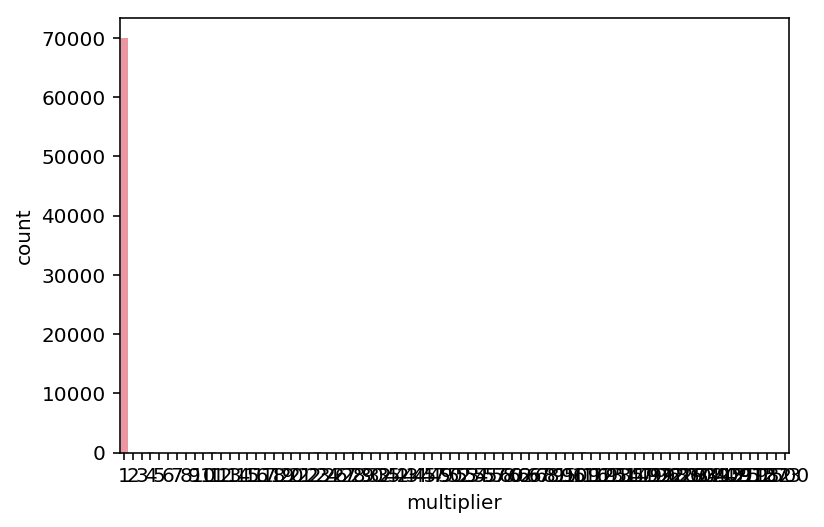

In [7]:
# если попробуем отобразить на диаграмме распределение, то на фоне 69934 "единичных" голосов остальные не видны
ax = sns.countplot(x = 'multiplier', data=df)


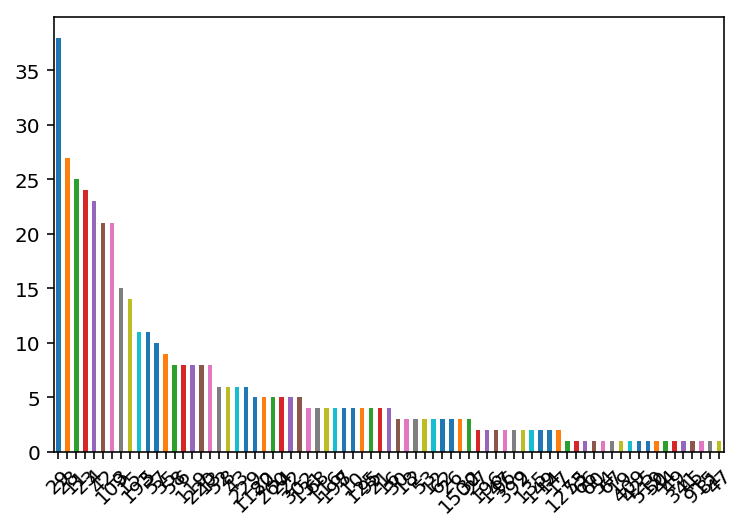

In [8]:
# посмотрим на распределение адресов с количеством голосов более 1 
df.multiplier.value_counts()[1:].plot(kind='bar', rot=45)

(array([28., 19., 10.,  5.,  2.,  2.,  0.,  2.,  0.,  0.,  2.,  1.,  2.,
         0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([ 1.  ,  2.85,  4.7 ,  6.55,  8.4 , 10.25, 12.1 , 13.95, 15.8 ,
        17.65, 19.5 , 21.35, 23.2 , 25.05, 26.9 , 28.75, 30.6 , 32.45,
        34.3 , 36.15, 38.  ]),
 <a list of 20 Patch objects>)

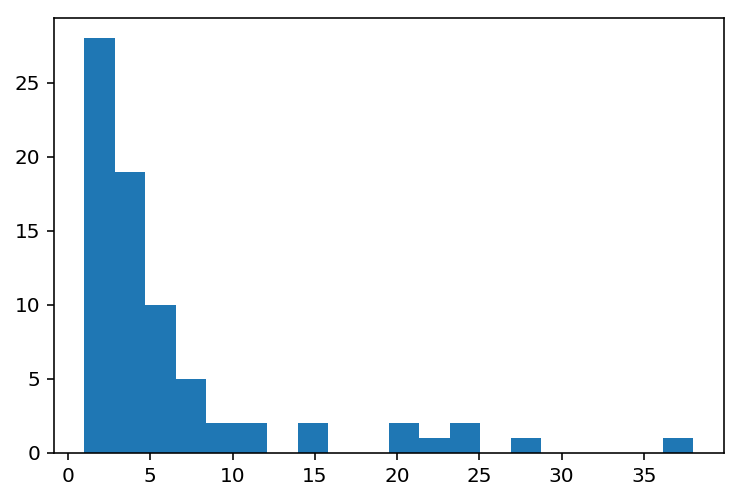

In [9]:
plt.hist(df.multiplier.value_counts()[1:], bins=20)

In [10]:
df.shape

(70382, 5)

In [11]:
multiple_addresses = (df.shape[0] - df.multiplier[df.multiplier==1].count()) / df.shape[0] *100
group_voices = np.sum(df.multiplier[df.multiplier!=1]) / np.sum(df.multiplier) *100
print('Казалось бы, можно не брать в расчет адреса, по которым люди голосовали группами, т.к. доля таких адресов всего: {0:.1f}%'
      .format(multiple_addresses))
print('Но доля таких людей существенна и составляет: {0:.1f}% от числа голосовавших'.format(group_voices))

Казалось бы, можно не брать в расчет адреса, по которым люди голосовали группами, т.к. доля таких адресов всего: 0.6%
Но доля таких людей существенна и составляет: 35.7% от числа голосовавших


In [12]:
# пока не будем работать с комментариями
del df['comment']

In [13]:
# посмотрим на получившийся датафрейм
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70382 entries, 0 to 70381
Data columns (total 4 columns):
x                70382 non-null float64
y                70382 non-null float64
comment_class    70382 non-null int64
multiplier       70382 non-null int64
dtypes: float64(2), int64(2)
memory usage: 5.2 MB


In [14]:
df.describe()

x             y  comment_class    multiplier
count  70382.000000  70382.000000   70382.000000  70382.000000
mean      37.588417     55.786013      -0.663835      1.545935
std        0.138217      0.066225       0.747885     16.986786
min       37.148813     55.496939      -1.000000      1.000000
25%       37.445608     55.743558      -1.000000      1.000000
50%       37.570887     55.792331      -1.000000      1.000000
75%       37.702822     55.848665      -1.000000      1.000000
max       37.931228     55.994174       1.000000   1500.000000

In [15]:
# видно, что максимальное количество к=голосовавших на одном адресе 1,5 тыс человек, интересно, сколлько таких адресов
df.multiplier[df.multiplier==1500]

54229    1500
54230    1500
54231    1500
Name: multiplier, dtype: int64

In [16]:
len(df.multiplier[df.multiplier==1500])

3

In [17]:
# каково распределение голосов за и против
df['comment_class'].value_counts()

-1    58552
 1    11830
Name: comment_class, dtype: int64

In [18]:
df2 = df['comment_class'].value_counts().reset_index()
df2

index  comment_class
0     -1          58552
1      1          11830

In [19]:
df2['index'][0] = 'Против'
df2['index'][1] = 'За'

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0,0.5,'Количество жителей')

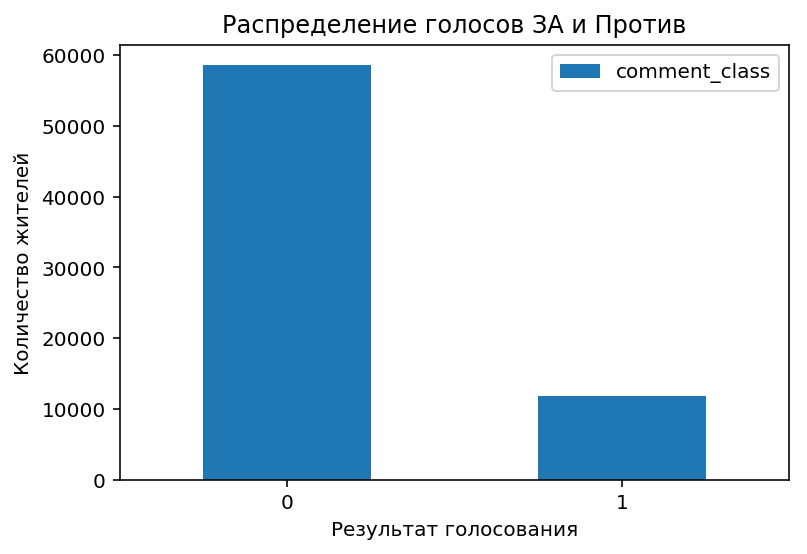

In [20]:
df2_plot = df2.plot(kind='bar', rot=0)
df2_plot.set_title('Распределение голосов ЗА и Против')
df2_plot.set_xlabel('Результат голосования')
df2_plot.set_ylabel('Количество жителей')

In [25]:
# сольем долготу и широту в одно поле, оставив 2 знака после запятой 
df[['x', 'y']].apply(lambda x: str(round(x[0], 2)) + ' ' + str(round(x[1], 2)), axis = 1).head()

0    37.61 55.78
1    37.61 55.78
2     37.6 55.74
3    37.56 55.73
4    37.57 55.73
dtype: object

In [26]:
# посмотрим наиболее популярные адреса
df[['x', 'y']].apply(lambda x: str(round(x[0], 2)) + ' ' + str(round(x[1], 2)), axis = 1).value_counts().head(10)

37.44 55.88    7338
37.45 55.79    4246
37.69 55.75    3569
37.8 55.81     3112
37.57 55.74    2900
37.81 55.8     2830
37.7 55.73     2760
37.77 55.76    2522
37.7 55.75     2130
37.68 55.75    2029
dtype: int64

In [27]:
df3 = df[['x', 'y']].apply(lambda x: str(round(x[0], 2)) + ' ' + str(round(x[1], 2)), axis = 1).value_counts().reset_index().head(20)

Text(0,0.5,'Количество записей на одном адресе')

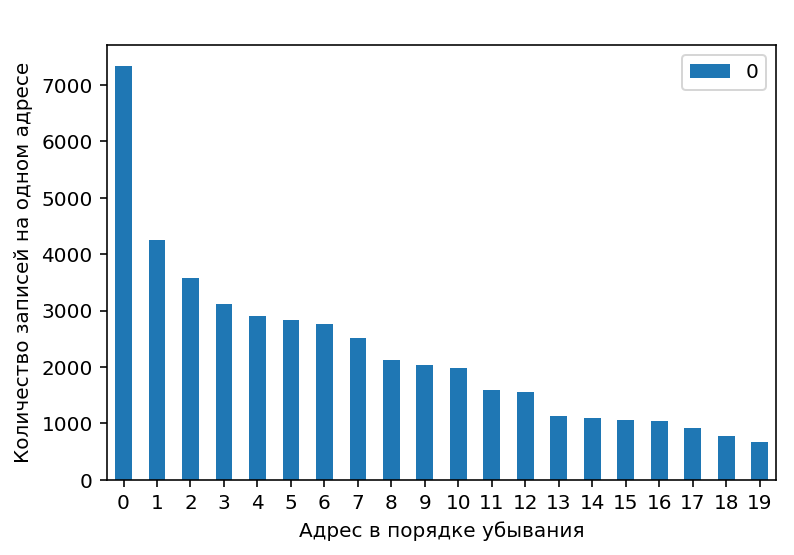

In [28]:
df3_plot = df3.plot(kind='bar', rot=0)
df3_plot.set_title(' ')
df3_plot.set_xlabel('Адрес в порядке убывания')
df3_plot.set_ylabel('Количество записей на одном адресе')

In [29]:
df.head()

x          y  comment_class  multiplier
0  37.612416  55.777454             -1           1
1  37.612416  55.777454             -1           1
2  37.603298  55.742108             -1           1
3  37.558526  55.728758             -1           1
4  37.566431  55.731794             -1           1

In [30]:
# добавим к датафрейму допонительным столбец 'coordinates', в котром будут координаты для каждой записи
df['coordinates'] = df[['x', 'y']].apply(lambda x: [str(round(x[1], 2)) + ', ' + str(round(x[0], 2))], axis = 1)

In [31]:
df.head(15)

x          y  comment_class  multiplier     coordinates
0   37.612416  55.777454             -1           1  [55.78, 37.61]
1   37.612416  55.777454             -1           1  [55.78, 37.61]
2   37.603298  55.742108             -1           1   [55.74, 37.6]
3   37.558526  55.728758             -1           1  [55.73, 37.56]
4   37.566431  55.731794             -1           1  [55.73, 37.57]
5   37.558526  55.728758             -1           1  [55.73, 37.56]
6   37.566431  55.731794             -1           1  [55.73, 37.57]
7   37.558957  55.723399             -1           1  [55.72, 37.56]
8   37.558957  55.723399             -1           1  [55.72, 37.56]
9   37.565767  55.734567             -1           1  [55.73, 37.57]
10  37.588853  55.789320             -1           1  [55.79, 37.59]
11  37.559640  55.768831             -1           1  [55.77, 37.56]
12  37.558616  55.723972             -1           1  [55.72, 37.56]
13  37.558023  55.723339             -1           1  [55.72, 37.56]
14  37.557520  55.723835             -1           1  [55.72, 37.56]

In [32]:
# сохраним координаты и тип голоса (за или против) в файлы для дальнейшей загрузки в Google maps
people_for = df[df.comment_class==1][['x', 'y', 'coordinates', 'comment_class']]
people_against = df[df.comment_class==-1][['x', 'y','coordinates', 'comment_class']]
people_for.to_excel('for.xlsx', index=False)
people_against.to_excel('against.xlsx', index=False)

In [33]:
# точки нанесены на карту

https://www.google.com/maps/d/edit?mid=1bfswaw-9a0IB_XjNJzTJJTvuCO8mmXH7&ll=55.742425852425384%2C37.58480775221699&z=12

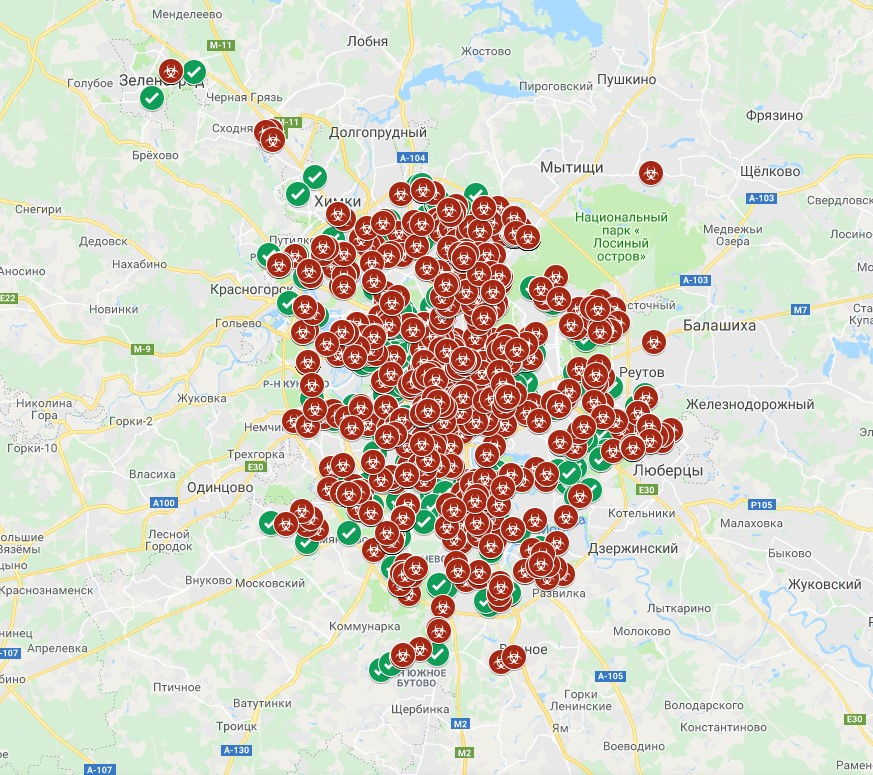

In [34]:
from IPython.display import Image
Image("Screenshot_3.jpg")

In [35]:
df.head()

x          y  comment_class  multiplier     coordinates
0  37.612416  55.777454             -1           1  [55.78, 37.61]
1  37.612416  55.777454             -1           1  [55.78, 37.61]
2  37.603298  55.742108             -1           1   [55.74, 37.6]
3  37.558526  55.728758             -1           1  [55.73, 37.56]
4  37.566431  55.731794             -1           1  [55.73, 37.57]

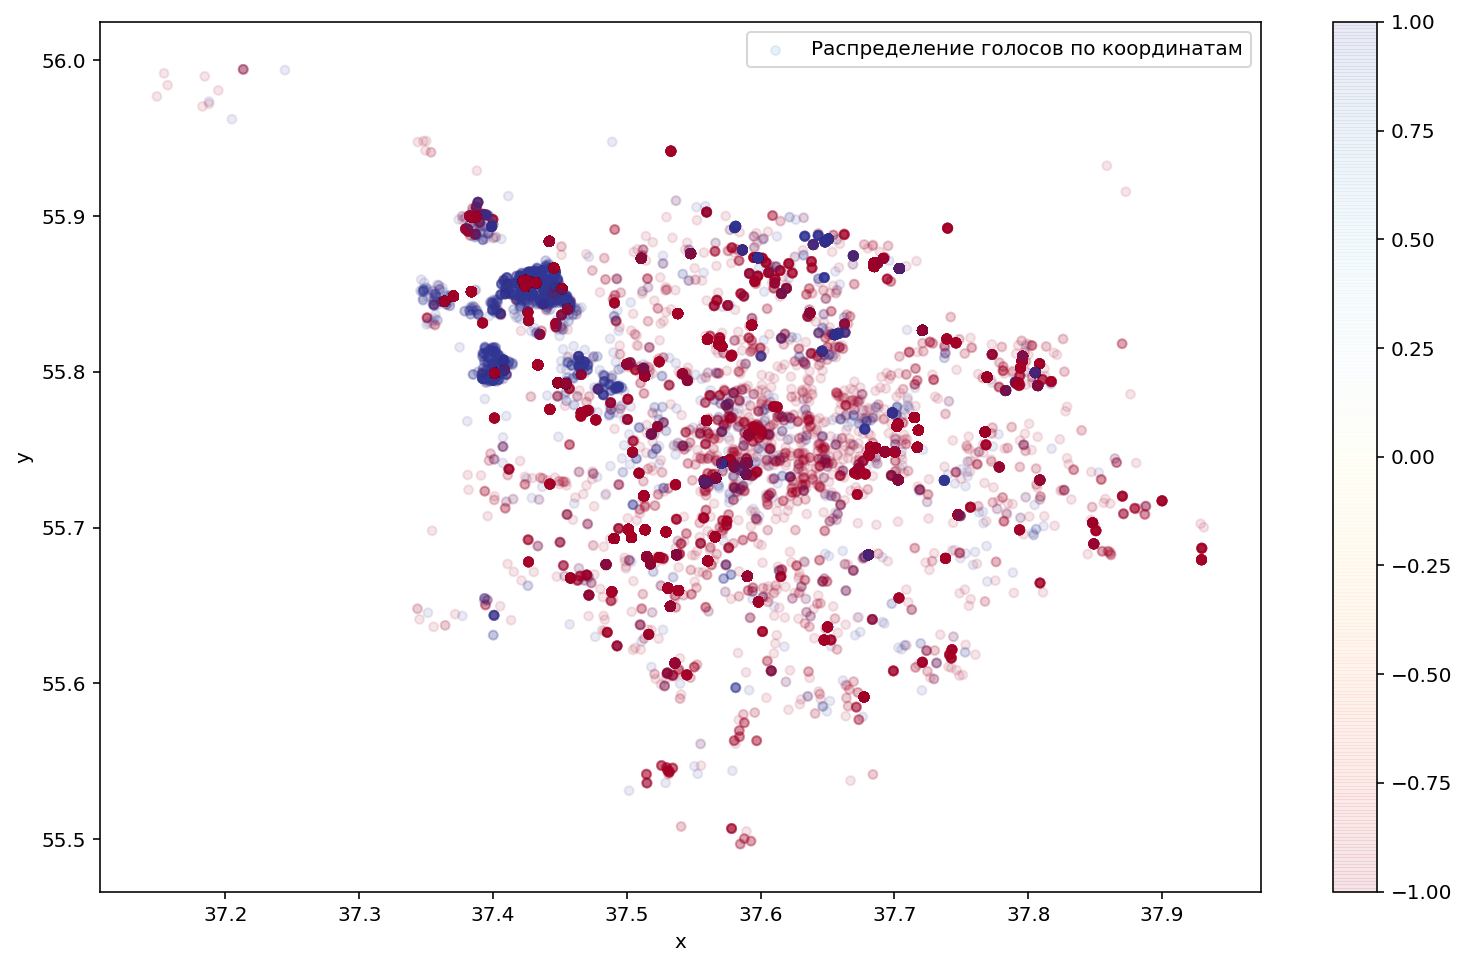

In [36]:
# визуализируем распределение голосов по координатам
df.plot(kind="scatter", x="x", y="y", alpha=0.1, label="Распределение голосов по координатам", figsize=(13,8),
    c=df['comment_class'], cmap=plt.get_cmap("RdYlBu"), colorbar=True , sharex=False)

In [37]:
# испортируем StandardScaler
#приведём данные по обеим осям к нормальному распределению
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


In [38]:
X = df[['x','y']]
y = df['comment_class']

In [39]:
X_scaled = scaler.fit_transform(X)

In [40]:
X_scaled

array([[ 0.17363392, -0.12923628],
       [ 0.17363392, -0.12923628],
       [ 0.10766492, -0.66296372],
       ...,
       [-1.21078898,  0.94742964],
       [-1.01223806,  0.10649107],
       [-0.99241408,  0.76417507]])

In [41]:
df[['x','y']].head()

x          y
0  37.612416  55.777454
1  37.612416  55.777454
2  37.603298  55.742108
3  37.558526  55.728758
4  37.566431  55.731794

In [42]:
# импортируем алгортмы кластеризации
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.metrics import adjusted_rand_score, silhouette_score

### KMeans
#### Подбор количества кластеров

KMeans минимизирует сумму квадратов расстояний объектов классов до их центроидов. В обученном классификаторе это значение находится в поле inertia_

Посчитаем значения inertia при разном количестве кластеров. Они объективно стремятся к нулю с ростом числа кластеров (предельный случай: каждый объект - кластер, расстояние = 0)

In [43]:
k_inertia = []
ks = range(5,13)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(X_scaled, )
    k_inertia.append(clf_kmeans.inertia_)

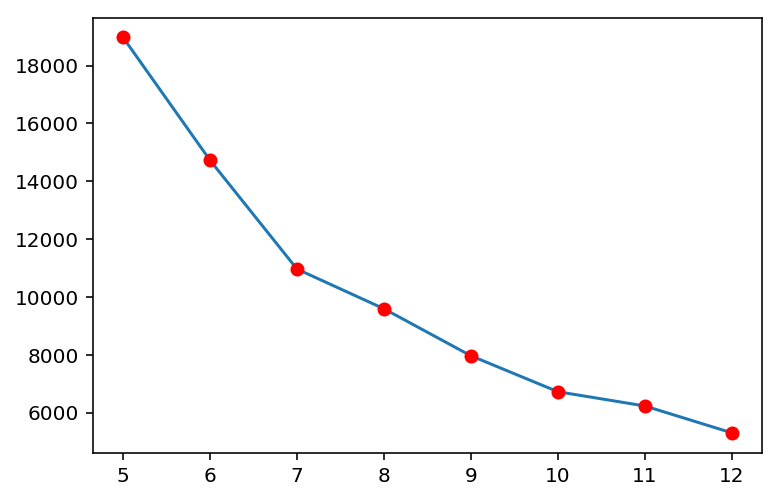

In [44]:
plt.plot(ks, k_inertia)
plt.plot(ks, k_inertia ,'ro')

Как подобрать оптимальное значение? Будем на каждом шаге смотреть изменение inertia, и в тот момент, когда оно резко замедлится (относительно предыдущего изменения) мы и остановимся

Для начала считаем сами изменения

$${inertia_{k+1}-inertia_{k}}$$

In [45]:
diff = np.diff(k_inertia)

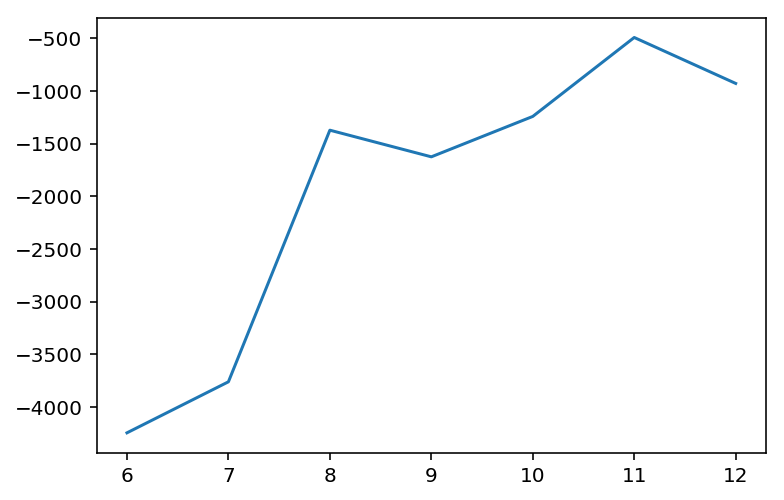

In [46]:
plt.plot(ks[1:], diff)

Теперь можно найти оптимальное число кластеров по этой формуле:

$$k_{opt} = argmin(\frac{inertia_{k+1}-inertia_{k}}{inertia_{k}-inertia_{k-1}})$$

In [47]:
diff_r = diff[1:] / diff[:-1]

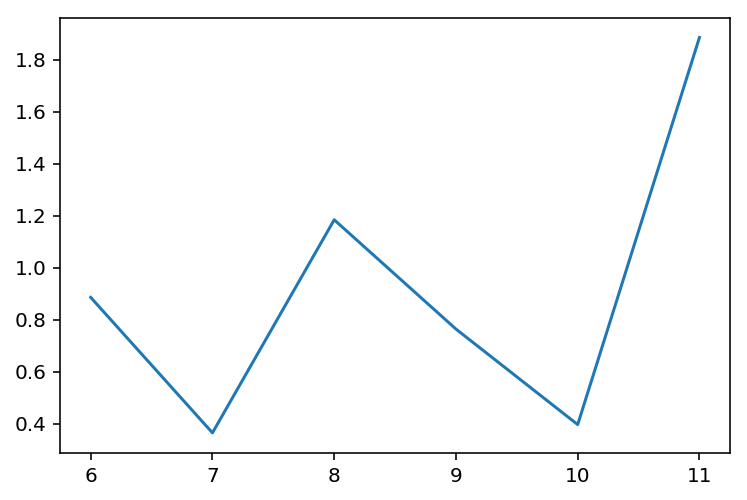

In [48]:
plt.plot(ks[1:-1], diff_r)

In [49]:
# оптимальное количество кластеров - 7
k_opt = ks[np.argmin(diff_r)+1]
k_opt

7

In [50]:
# хотя из графика видно, что 9 почти так же хорошо, как 7. Возьмем 9

In [51]:
alpha=0.1
clusters = KMeans(n_clusters=9).fit_predict(X_scaled)

1. визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)


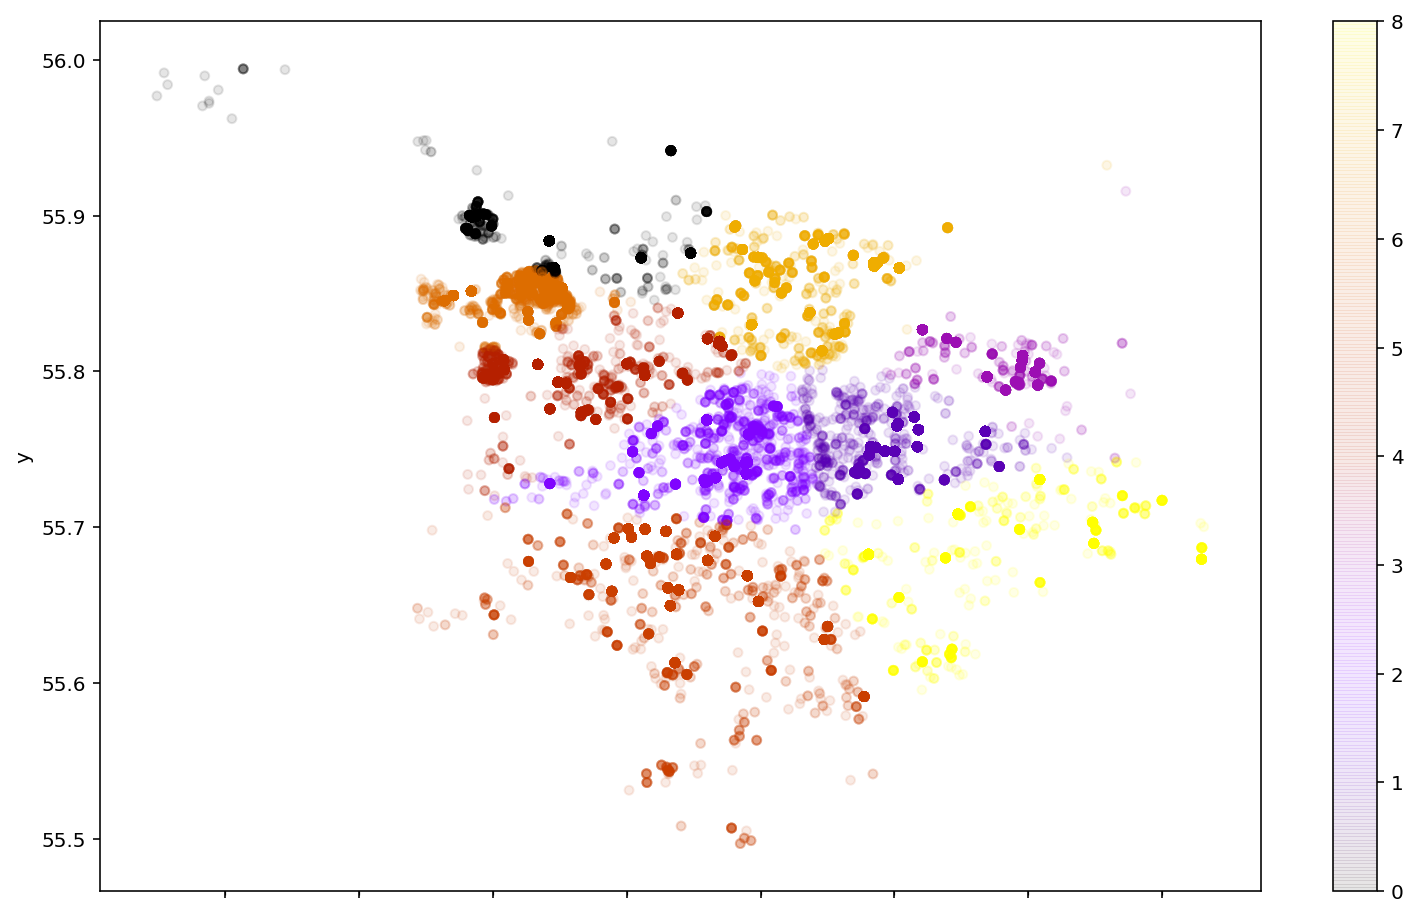

In [52]:
df.plot(kind="scatter", x='x', y='y', c=clusters, alpha=0.1, figsize=(13,8),
       cmap=plt.get_cmap("gnuplot"), colorbar = True)

2. Исследуем скопления голосов за и против отдельно (определим для них кластеры)


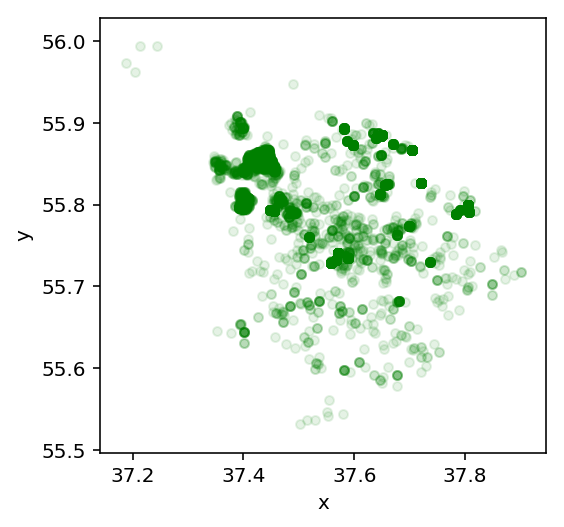

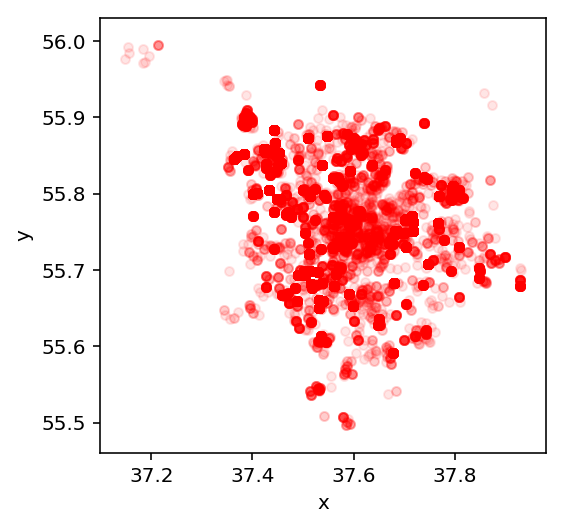

In [53]:
df[df['comment_class']==1].plot(kind="scatter", x='x', y='y', alpha=0.1, figsize=(4,4), c='green')
df[df['comment_class']==-1].plot(kind="scatter", x='x', y='y', alpha=0.1, figsize=(4,4), c='red')

По знакомой уже схеме ищем оптимальное кол-во кластеров для голосующих За

In [54]:
df_for = df[df['comment_class']==1][['x','y']]

X_scaled = scaler.fit_transform(df_for)

k_inertia = []
ks = range(5,13)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(X_scaled, )
    k_inertia.append(clf_kmeans.inertia_)



In [55]:
diff = np.diff(k_inertia)
diff_r = diff[1:] / diff[:-1]

Подберем оптимальное число кластеров

In [56]:
# оптимальное количество кластеров - 8
k_opt = ks[np.argmin(diff_r)+1]
k_opt

8

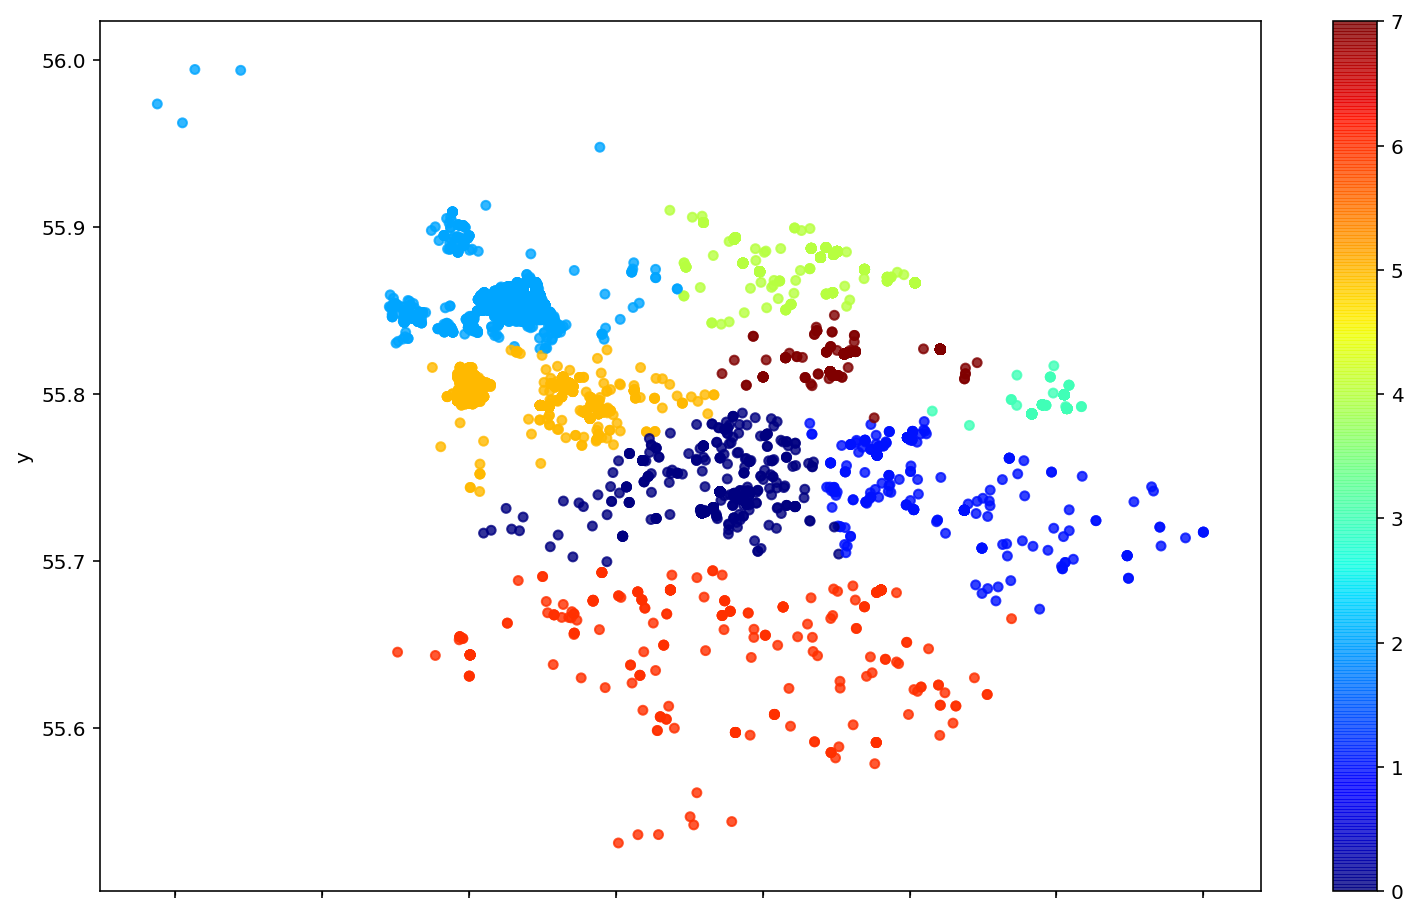

In [57]:
clusters = KMeans(n_clusters=k_opt).fit_predict(X_scaled)

df_for.plot(kind="scatter", x='x', y='y', c=clusters, alpha=0.8, figsize=(13,8),
       cmap=plt.get_cmap("jet"))

Ищем оптимальное кол-во кластеров для голосующих Против

In [58]:
df_against = df[df['comment_class']==-1][['x','y']]

X_scaled = scaler.fit_transform(df_against)

k_inertia = []
ks = range(5,13)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(X_scaled, )
    k_inertia.append(clf_kmeans.inertia_)



In [59]:
diff = np.diff(k_inertia)
diff_r = diff[1:] / diff[:-1]

In [60]:
# оптимальное количество кластеров - 11
k_opt = ks[np.argmin(diff_r)+1]
k_opt

10

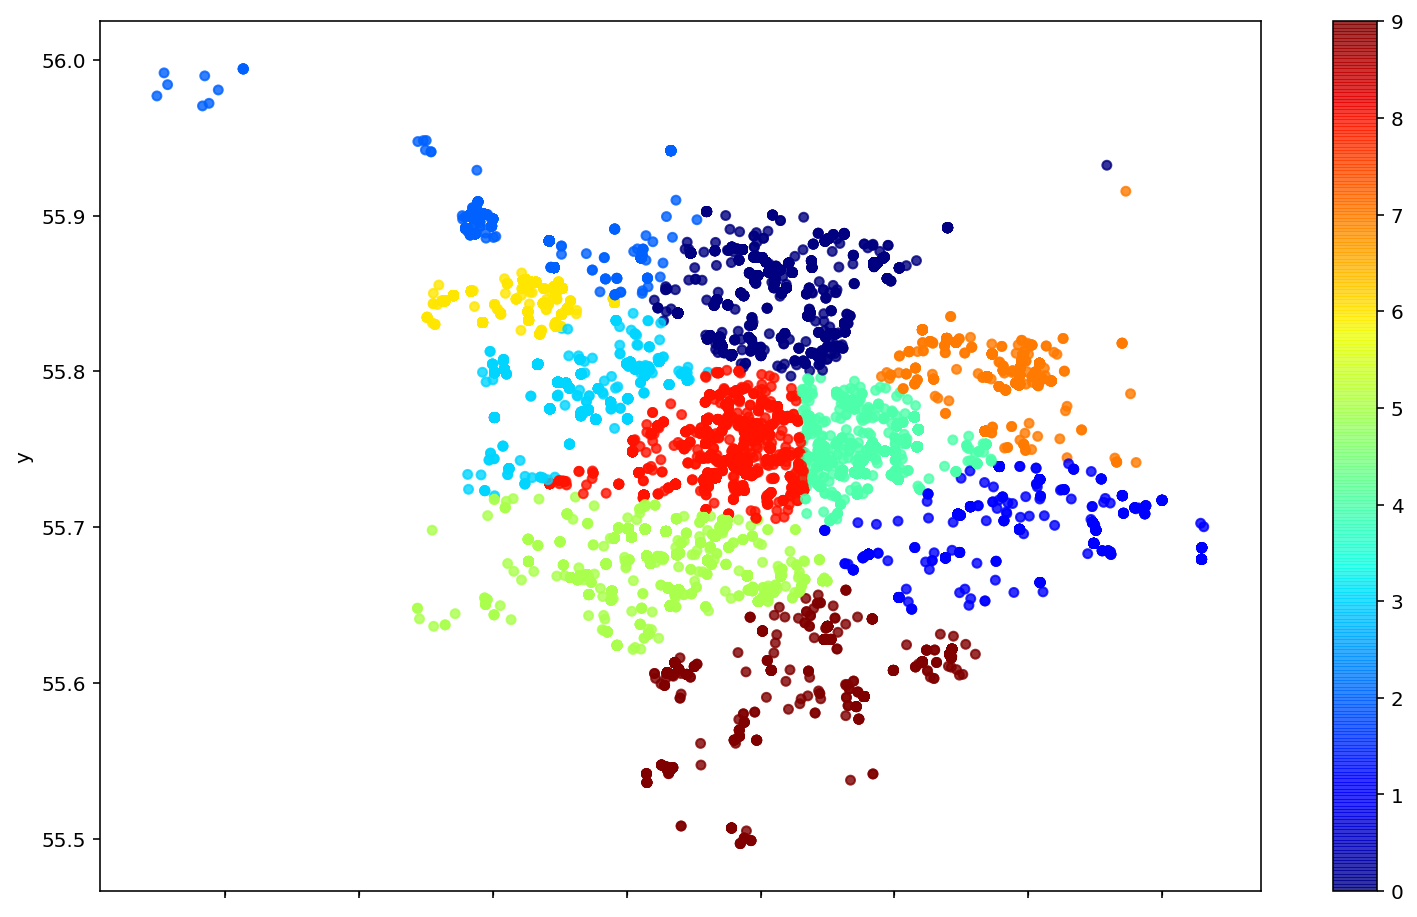

In [61]:
clusters = KMeans(n_clusters=k_opt).fit_predict(X_scaled)

df_against.plot(kind="scatter", x='x', y='y', c=clusters, alpha=0.8, figsize=(13,8),
       cmap=plt.get_cmap("jet"))

### DBSCAN
#### Объединим в кластеры наиболее активные районы

Рассматриваем объекты как ядра,
вокруг которых собираются другие
объекты

Если не собираются - это выброс

Если ядра связаны - то они и
достижимые из них объекты
образуют кластер

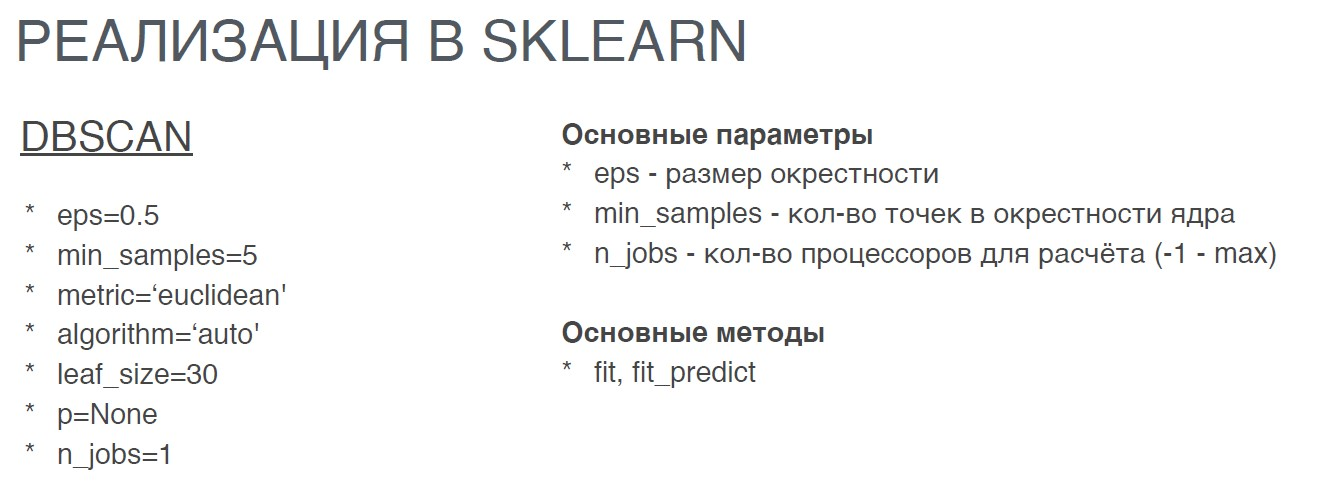

In [62]:
Image("Screenshot_5.jpg")

In [67]:
X_scaled = scaler.fit_transform(X)

clf = DBSCAN(eps = 0.5, metric = 'euclidean',min_samples=10000)
clusters = clf.fit_predict(X_scaled)

In [68]:
clusters.shape

(70382,)

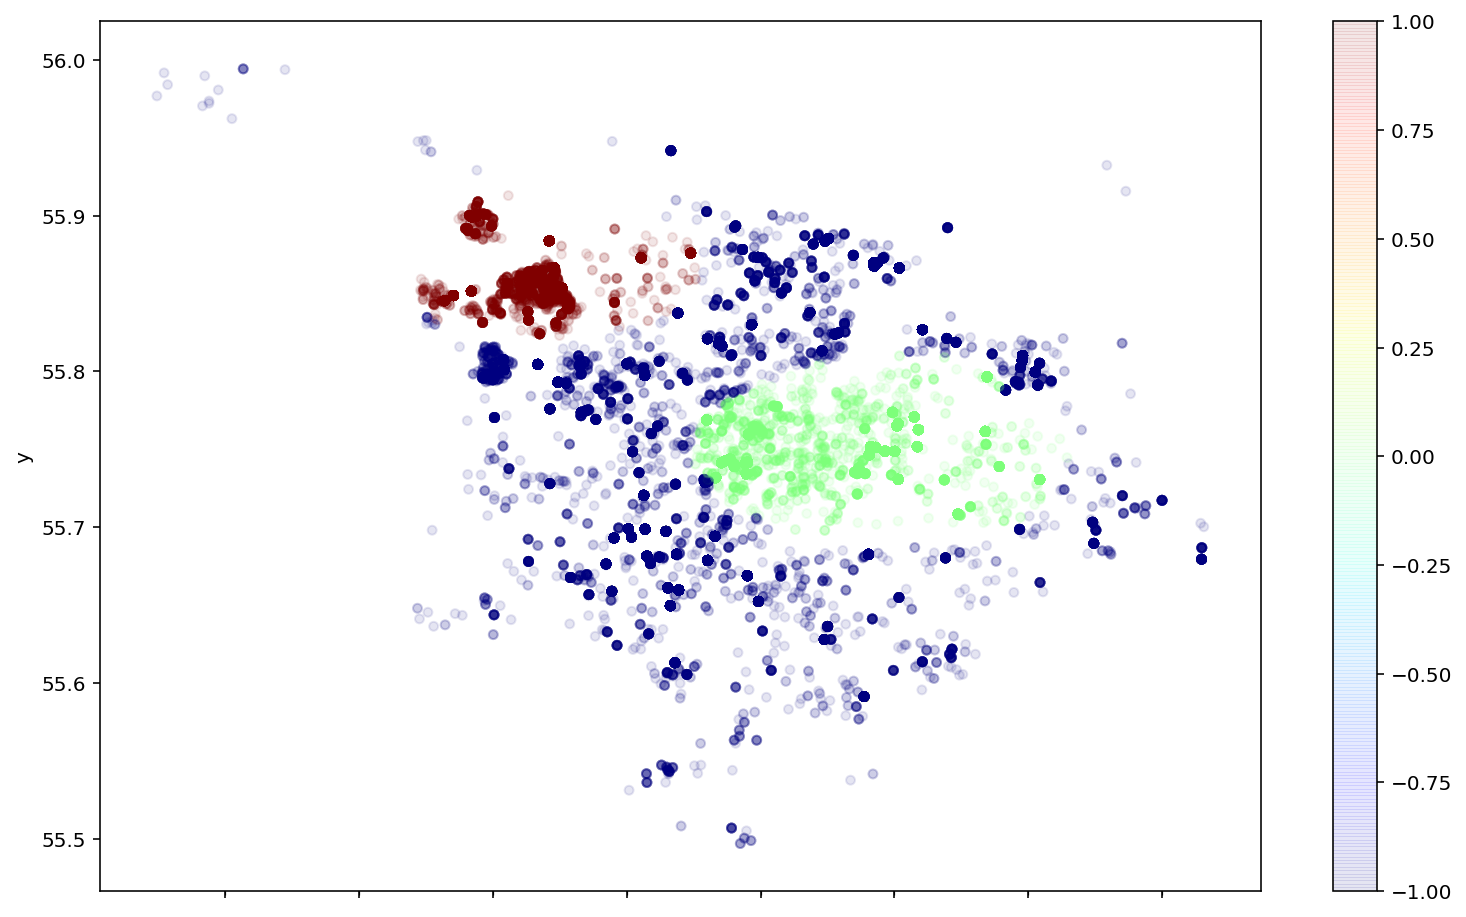

In [69]:
df.plot(kind="scatter", x='x', y='y', c=clusters, alpha=0.1, figsize=(13,8),
       cmap='jet', colorbar = True)

In [70]:
set(clusters)

{-1, 0, 1}

In [73]:
#считаться будет долго

k_inertia = []
ks = list(range(1,10))

for k in ks:
    clf = DBSCAN(eps = (k/10), metric = 'euclidean',min_samples=10000)
    clusters = clf.fit_predict(X_scaled)
    clusters_dbscan = set(clusters)
    print('Размер окрестности: {0} --- Кластеров: {1}'.format(k/10, len(clusters_dbscan)))

Размер окрестности: 0.1 --- Кластеров: 1
Размер окрестности: 0.2 --- Кластеров: 2
Размер окрестности: 0.3 --- Кластеров: 3
Размер окрестности: 0.4 --- Кластеров: 3
Размер окрестности: 0.5 --- Кластеров: 3
Размер окрестности: 0.6 --- Кластеров: 3
Размер окрестности: 0.7 --- Кластеров: 3
Размер окрестности: 0.8 --- Кластеров: 2
Размер окрестности: 0.9 --- Кластеров: 2


Принадлежность к активным районам можно записать с новый столбец датафрейма 

In [74]:
X_scaled = scaler.fit_transform(X)
# для размера окрестности выставим 0,3
clf = DBSCAN(eps = 0.3, metric = 'euclidean',min_samples=10000)
clusters = clf.fit_predict(X_scaled)

In [75]:
df['active_district'] = clusters

In [76]:
df.head()

x          y  comment_class  multiplier     coordinates  \
0  37.612416  55.777454             -1           1  [55.78, 37.61]   
1  37.612416  55.777454             -1           1  [55.78, 37.61]   
2  37.603298  55.742108             -1           1   [55.74, 37.6]   
3  37.558526  55.728758             -1           1  [55.73, 37.56]   
4  37.566431  55.731794             -1           1  [55.73, 37.57]   

   active_district  
0               -1  
1               -1  
2               -1  
3               -1  
4               -1

In [77]:
# получили три активных района
df['active_district'].value_counts()

-1    43733
 0    15105
 1    11544
Name: active_district, dtype: int64

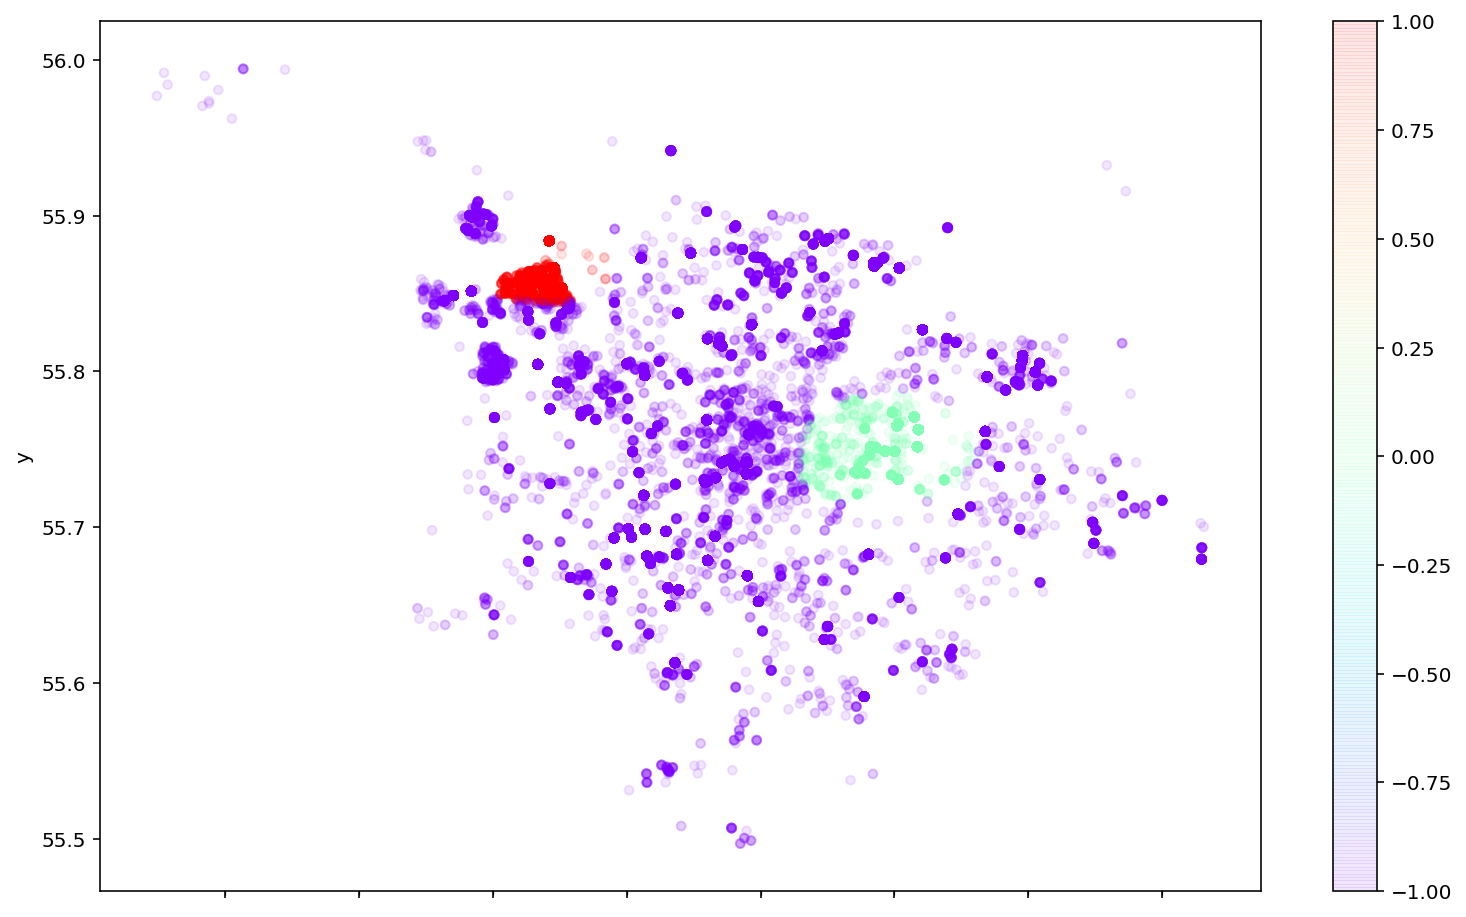

In [82]:
df.plot(kind="scatter", x='x', y='y', c=clusters, alpha=0.1, figsize=(13,8),
       cmap='rainbow', colorbar = True)

### Визуализируем результаты

In [84]:
# установим библиотеку folium
!pip install folium

In [86]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster

MO_COORDINATES = (55.764414, 37.647859)
votes = df

map = folium.Map(location=MO_COORDINATES, zoom_start=10)

mc = MarkerCluster()

for each in votes.iterrows():
    mc.add_child(folium.Marker(location=[each[1]['y'],each[1]['x']]))
 
map.add_child(mc)

map.save('cluster_map.html')

С картой в html можно ппоиграться (увеличить, уменьшить)

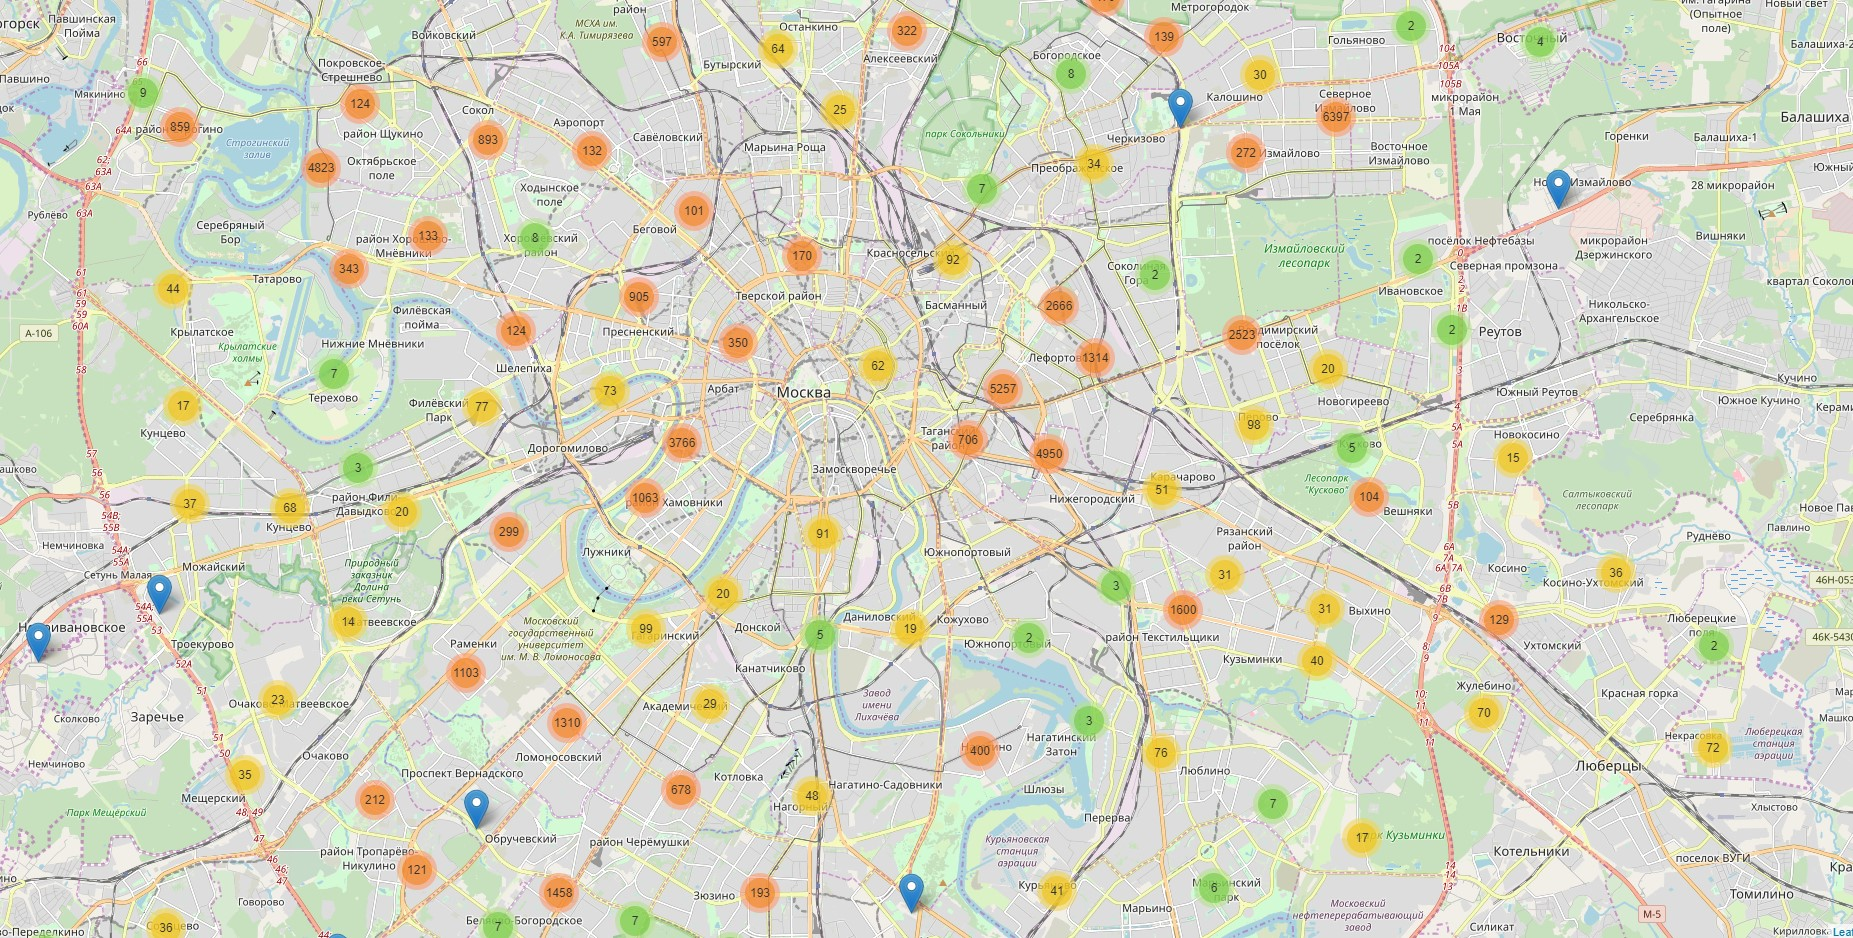

In [88]:
Image("Screenshot_7.jpg")

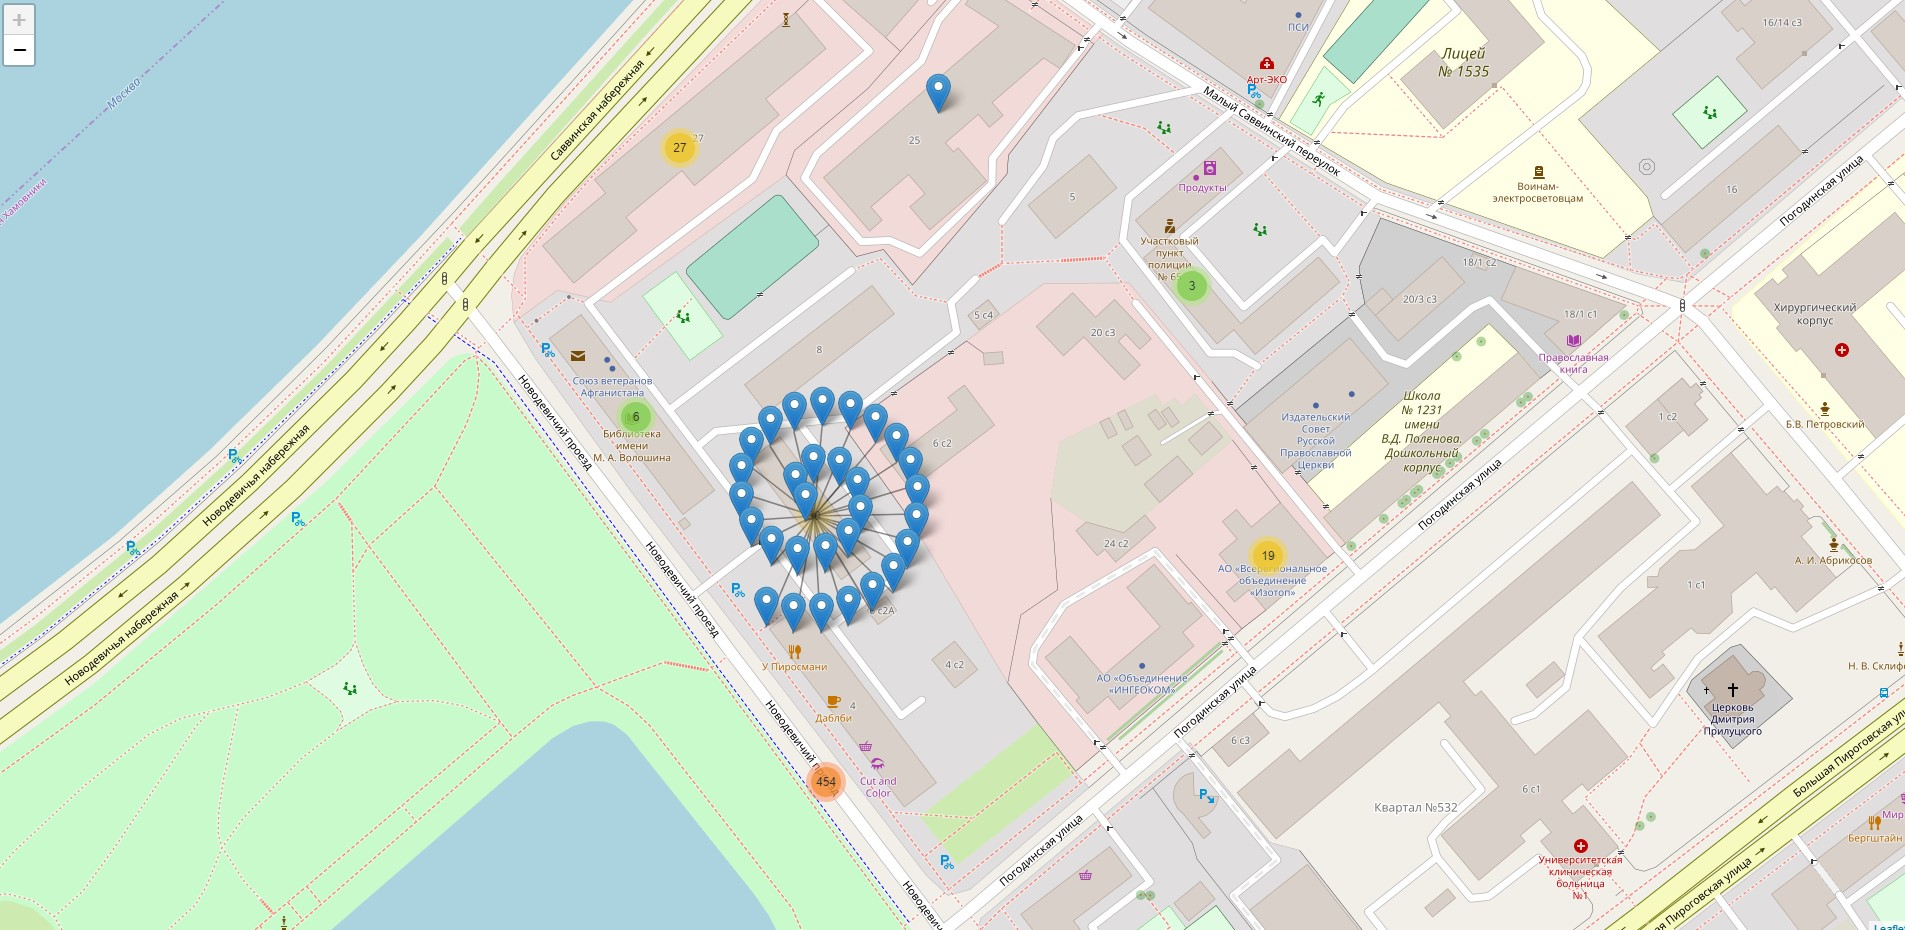

In [87]:
Image("Screenshot_6.jpg")